<center> <img src='https://drive.google.com/uc?export=download&id=14tXQSr1tpJJIu6bd1WMikTGtN5LXbpm6'> </center>


<center> <img src='https://drive.google.com/uc?export=download&id=1SNZfRp1ts40rPqparvX3H_smoAtCxeVO'> </center>


<p align='right'><font size ='20'><b>الرّاوية</b></font></p>
<p align='right'><b>يَرْوِي لَك الخَيَال شِعْرَاً </b></p>

---


<p align='right'> 
 يهدف هذا المشروع إلى تطوير نظام رواية للشعر العربي بناء على الصورة المقدمة له باستخدام تقنيات الذكاء الاصطناعي، 
 هذا المشروع هو الأول من نوعه لنمذجة العلاقة بين البيانات الأدبية وما تحويه من مشاعر ودلالات ومعاني والبيانات المرئية، يتضمن تطوير هذا المشروع بناء أول مجموعة بيانات أدبية-مرئية في اللغة العربية، والتي يمكن استخدامها في العديد من الأبحاث، كذلك يساهم هذا النظام في تعزيز استخدام النصوص الأدبية العربية في وسائل التواصل الاجتماعي.
</p>



<p align='right'><b>فضلاً اتبع التعليمات التالية لتشغيل نموذج رواية الشعر</b></p>

In [ ]:
#@title الكود الخاص ببدء النموذج قم بالضغط على زر التشغيل المجاور (تشغيل هذه الخلية إلزامي)

!pip install git+https://github.com/openai/CLIP.git

import torch
import clip

import os
!gdown https://drive.google.com/uc?id=1CxCdV2O-p2ELegwTebmxYz7lDxVSB-ei&export=download
!gdown https://drive.google.com/uc?id=1-5kKs4YK3VUUW7m_vgNvnw_HrRGqcoUe&export=download




<p align='right'><b>:نقدم النموذج بأربع خيارات للتشغيل</b></p>
<p align='right'>١. النموذج الأساسي عن طريق رفع الصورة </p>
<p align='right'> ٢. النموذج المدرّب عن طريق رفع الصورة</p>
<p align='right'>٣. النموذج الأساسي عن طريق وضع رابط صورة من الإنترنت</p>
<p align='right'>٣. النموذج المدرّب عن طريق وضع رابط صورة من الإنترنت</p>


---



<p align='right'><b> ١. النموذج الأساسي عن طريق رفع الصورة</b></p>


Saving friend.png to friend (3).png
الصورة المراد معالجتها


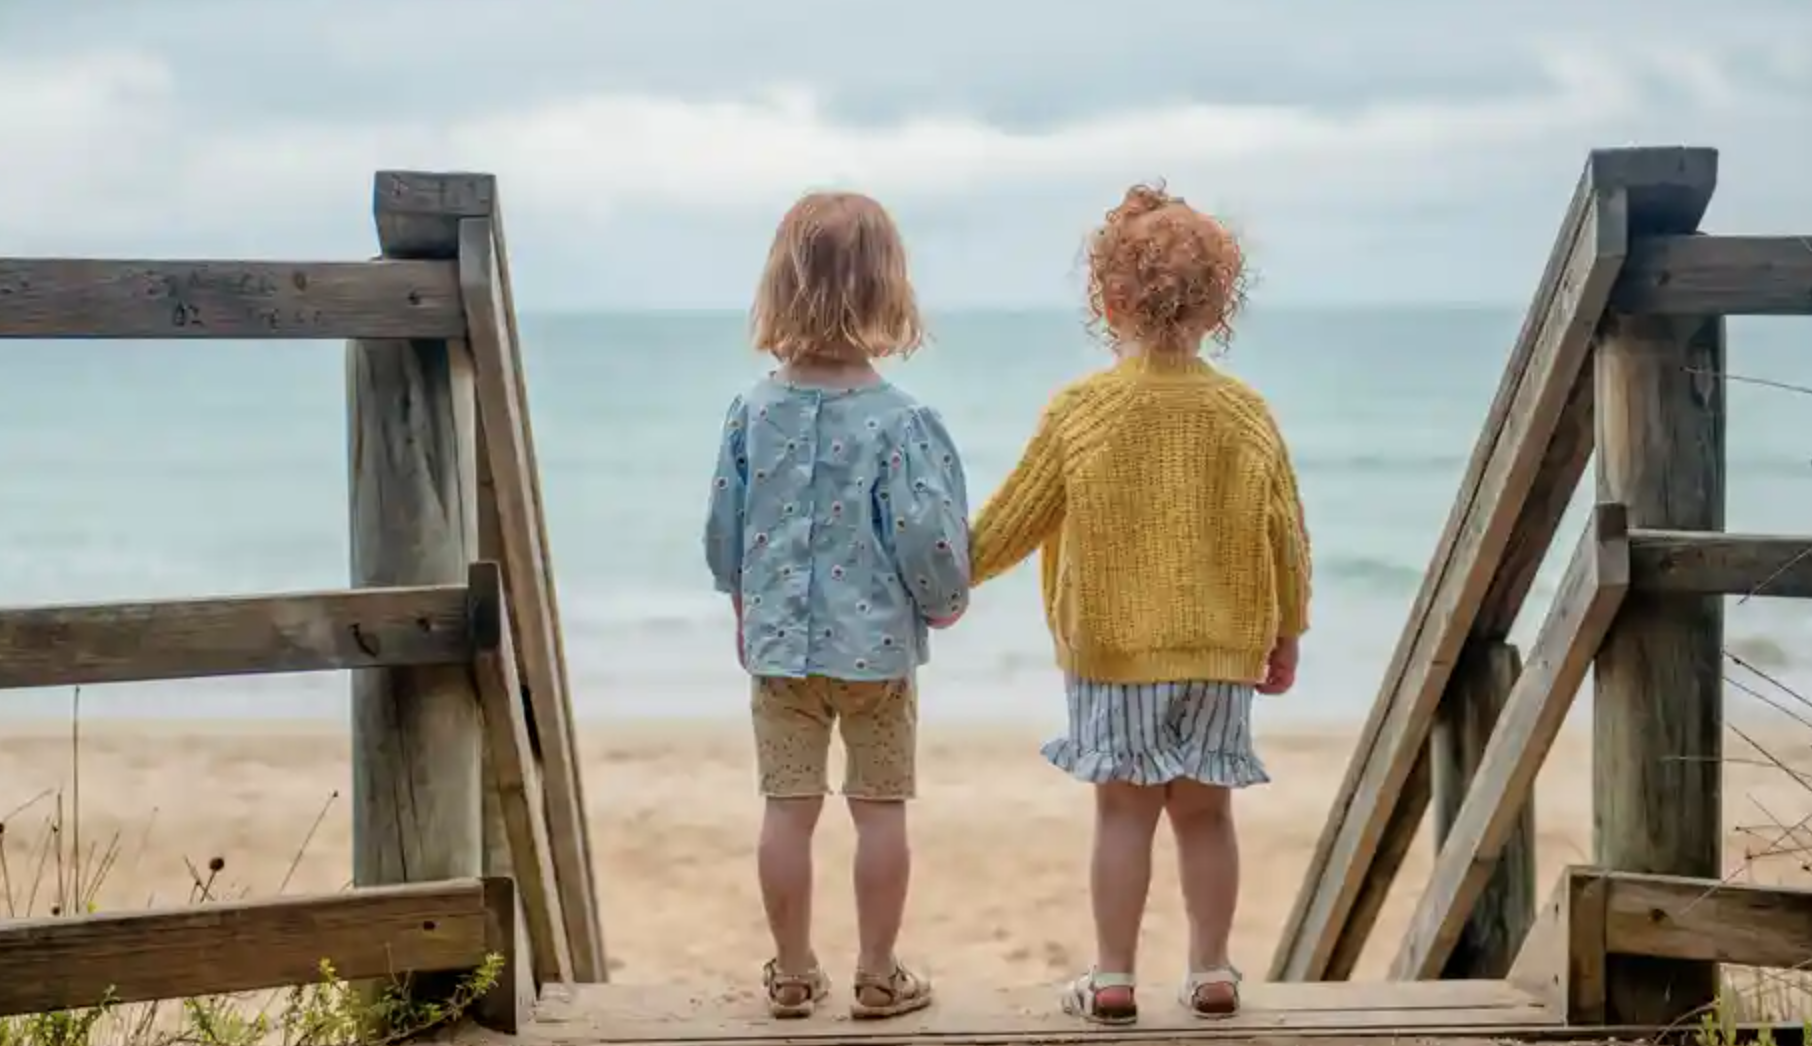

النصوص الشعرية المقترحة


ليس الصديق الذي ترضى بصحبته إلا المشارك في الإعسار واليسر
وأحب إخواني إلي أبشهم بصديقه في سره أو جهره
كأني لم أشج العدو بقربه و لم أغشه قبل الصديق مسلما
الطاهر الشيمة الصديق في زمن وجود أمثاله فيه من العجب
زمان لم أجد فيه صديقا أشاطره سروري إن فرحت


In [5]:
#@title قم بالضغط على زر التشغيل المجاور سيظهر لك زر لتحميل الصورة قم بتحميل صورة وانتظر ظهور النتائج

from PIL import Image
from google.colab import files
import pandas as pd
import requests
import urllib.request
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"

# load model and image preprocessing
model, preprocess = clip.load("ViT-B/32", device=device, jit=False)

pd.set_option('display.max_colwidth', None)

df = pd.read_csv("/content/data.csv")
tags = df.groupby(['tags'])['tags'].count().rename_axis('t').reset_index(name='counts')
tags_list = tags['t'].values.tolist()
#print(tags_list)
def prefix_them(text, in_lang='auto', out_lang='en'):
  return "a photo of "+text
tags_list = [prefix_them(str(x)) for x in tags_list]

text = clip.tokenize(tags_list, truncate=True).to(device)


image = files.upload().keys()
image_path = '/content/' + list(image)[0]
image = Image.open(image_path)
print("الصورة المراد معالجتها")
display(image)
image = preprocess(image).unsqueeze(0).to(device)

with torch.no_grad():
    text_features = model.encode_text(text)
    image_features = model.encode_image(image)
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

#print(probs)
#print("Label probs:", probs.max(1))
#print("Label probs:", tags_list[int(probs.argmax(1))])
#print("Label probs:", tags_list[int(probs.argmax(1))])
key = tags_list[int(probs.argmax(1))]
key_df = df[df['tags'].str.contains(key.replace("a photo of ","") )].sample(n=5)
key_df = key_df.drop(['tags'], axis=1)
print("النصوص الشعرية المقترحة")
key_df.style.hide_index().hide_columns()






---


<p align='right'><b> ٢. النموذج المدرّب عن طريق رفع الصورة</b></p>


Saving mountain.png to mountain (2).png
الصورة المراد معالجتها


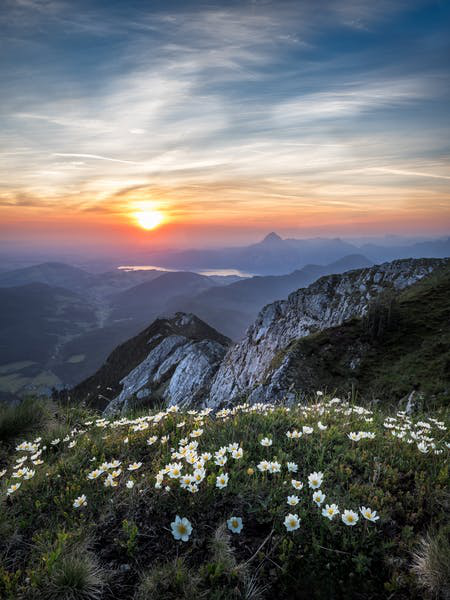

النصوص الشعرية المقترحة


وجر إليهم في جبال من القنا مناياهم بالقتل جحفلك المجر
فلئن هوى جبل فقد أثوى لنا خلفا له ملأ الكنانة أنصلا
ويا جبل الله فى أرضه لرواده أعفنا أن تزولا
أتينا إليها من جبال مهولة يكاد بها الماشي يخر بمزلق
توارى بنصف خلال السحب ونصف على جبل لم يغب


In [9]:
#@title قم بالضغط على زر التشغيل المجاور سيظهر لك زر لتحميل الصورة قم بتحميل صورة وانتظر ظهور النتائج


import torch.nn as nn
from PIL import Image
from google.colab import files
import pandas as pd
import requests
import urllib.request
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"

class CLIP_Net(nn.Module):
    def __init__(self, features_image=1280,features_text=768,projection_dim=256,normalize=1):
        super(CLIP_Net, self).__init__()

        self.backbone,  self.preprocessor = clip.load('ViT-B/32', device,jit=False)
        self.Dense=nn.Linear(768,512).to(device)

        self.logit_scale = nn.Parameter(torch.ones([]))

    def forward(self,x_im,x_tx):
    
        image_features, text_features = self.backbone(x_im, x_tx)
        

        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        logit_scale = self.logit_scale.exp()
        logits_per_iamge = logit_scale * image_features @ text_features.t()
        logits_per_text = logit_scale * text_features @ image_features.t()

        return logits_per_iamge, logits_per_text

Poems_model = CLIP_Net().to(device)


checkpoint = torch.load("/content/Poems_model_50_epochs.pt")
checkpoint["input_resolution"] = 224 
checkpoint["context_length"] = 77 
checkpoint["vocab_size"] = Poems_model.backbone.vocab_size 
res = {str(key).replace("backbone.",""): val for key, val in checkpoint['model_state_dict'].items()}
Poems_model.backbone.load_state_dict(res,strict=False)

pd.set_option('display.max_colwidth', None)

df = pd.read_csv("/content/data.csv")
tags = df.groupby(['tags'])['tags'].count().rename_axis('t').reset_index(name='counts')
tags_list = tags['t'].values.tolist()
#print(tags_list)
def prefix_them(text, in_lang='auto', out_lang='en'):
  return "a photo of "+text
tags_list = [prefix_them(str(x)) for x in tags_list]

text = clip.tokenize(tags_list, truncate=True).to(device)


image = files.upload().keys()
image_path = '/content/' + list(image)[0]
image = Image.open(image_path)
print("الصورة المراد معالجتها")
display(image)
image = Poems_model.preprocessor(image).unsqueeze(0).to(device)

with torch.no_grad():
    text_features = Poems_model.backbone.encode_text(text)
    image_features = Poems_model.backbone.encode_image(image)
    logits_per_image, logits_per_text = Poems_model.backbone(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

#print(probs)
#print("Label probs:", probs.max(1))
#print("Label probs:", tags_list[int(probs.argmax(1))])
#print("Label probs:", tags_list[int(probs.argmax(1))])
key = tags_list[int(probs.argmax(1))]
key_df = df[df['tags'].str.contains(key.replace("a photo of ","") )].sample(n=5)
key_df = key_df.drop(['tags'], axis=1)
print("النصوص الشعرية المقترحة")

key_df.style.hide_index().hide_columns()

#display(key_df)






---


<p align='right'><b> ٣. النموذج الأساسي عن طريق وضع رابط من الإنترنت</b></p>

<p align='right'> ضع رابط صورة من الإنترنت في الحقل التالي، على سبيل المثال الروابط التي بالأسفل بعدها قم بتشغيل الخلية</p>




*  https://images.pexels.com/photos/1266810/pexels-photo-1266810.jpeg
*  https://images.pexels.com/photos/1266810/pexels-photo-1266810.jpeg


In [15]:
#@title 
image_url = 'https://images.pexels.com/photos/617967/pexels-photo-617967.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1' #@param {type:"string"}


الصورة المراد معالجتها


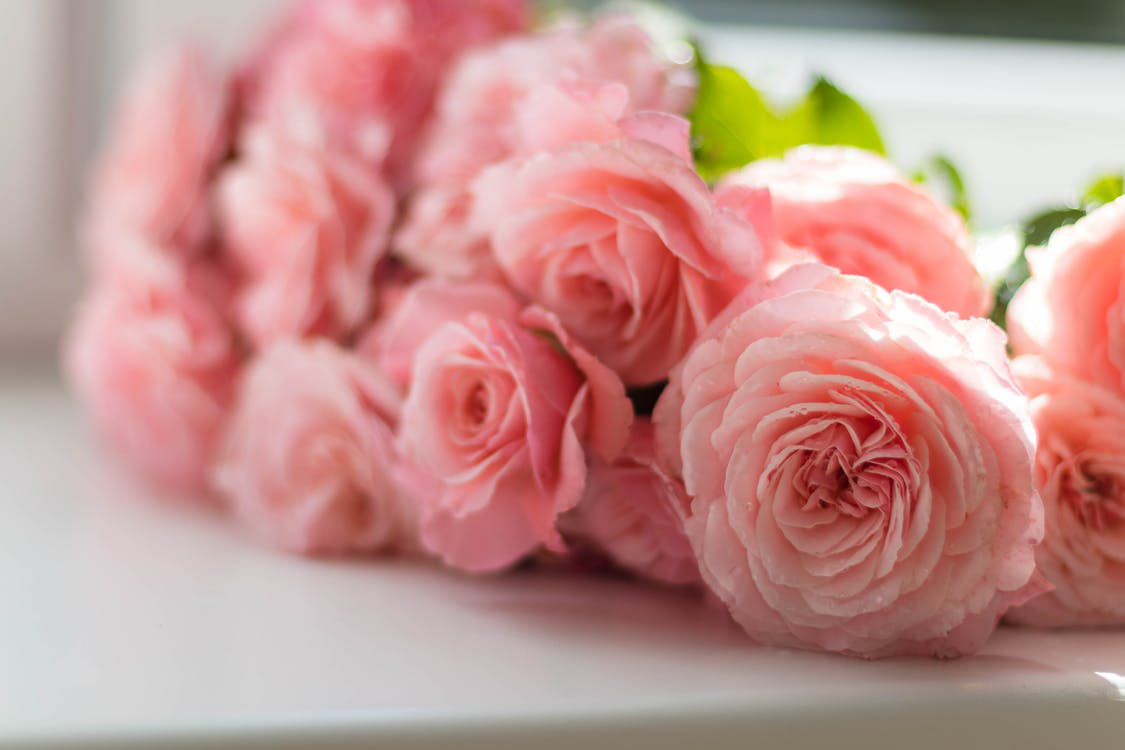

النصوص الشعرية المقترحة


يا راقدا ونسيم الورد منتبه في ربقة القفص والأطيار تنتحب
صغيرة يا فجر الندى متصاعدا أأنت منام الورد يغشى اللياليا؟
في كل برعم زهر وعد عاصفة فالريح ان لامسته مرة يثب
عمرو وسعد، يا فرزدق، فيهم زهر النجوم وباذخات الأجبل
يباكرن فينا نجعة العتب بيننا كما انتجع الورد العطاش اللواهث


In [17]:
#@title

from PIL import Image
from google.colab import files
import pandas as pd
import requests
import urllib.request
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"

# load model and image preprocessing
model, preprocess = clip.load("ViT-B/32", device=device, jit=False)

pd.set_option('display.max_colwidth', None)

df = pd.read_csv("/content/data.csv")
tags = df.groupby(['tags'])['tags'].count().rename_axis('t').reset_index(name='counts')
tags_list = tags['t'].values.tolist()
#print(tags_list)
def prefix_them(text, in_lang='auto', out_lang='en'):
  return "a photo of "+text
tags_list = [prefix_them(str(x)) for x in tags_list]

text = clip.tokenize(tags_list, truncate=True).to(device)

#add pre selected examples :
#https://images.pexels.com/photos/1266810/pexels-photo-1266810.jpeg?auto=compress&cs=tinysrgb&w=300&h=300&dpr=2
#image_url= "https://images.pexels.com/photos/1266810/pexels-photo-1266810.jpeg?auto=compress&cs=tinysrgb&w=300&h=300&dpr=2"
# load image
image = Image.open(requests.get(image_url, stream=True).raw)

print("الصورة المراد معالجتها")
display(image)
image = preprocess(image).unsqueeze(0).to(device)

with torch.no_grad():
    text_features = model.encode_text(text)
    image_features = model.encode_image(image)
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

#print(probs)
#print("Label probs:", probs.max(1))
#print("Label probs:", tags_list[int(probs.argmax(1))])
#print("Label probs:", tags_list[int(probs.argmax(1))])
key = tags_list[int(probs.argmax(1))]
key_df = df[df['tags'].str.contains(key.replace("a photo of ","") )].sample(n=5)
key_df = key_df.drop(['tags'], axis=1)
print("النصوص الشعرية المقترحة")

key_df.style.hide_index().hide_columns()
#display(key_df)

---


<p align='right'><b> ٤. النموذج المدرّب عن طريق وضع رابط من الإنترنت</b></p>

<p align='right'> ضع رابط صورة من الإنترنت في الحقل التالي، على سبيل المثال الروابط التي بالأسفل بعدها قم بتشغيل الخلية</p>




*  https://images.pexels.com/photos/1266810/pexels-photo-1266810.jpeg
* https://images.pexels.com/photos/210205/pexels-photo-210205.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1

In [29]:
#@title 
image_url = 'https://images.pexels.com/photos/7862888/pexels-photo-7862888.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1' #@param {type:"string"}


الصورة المراد معالجتها


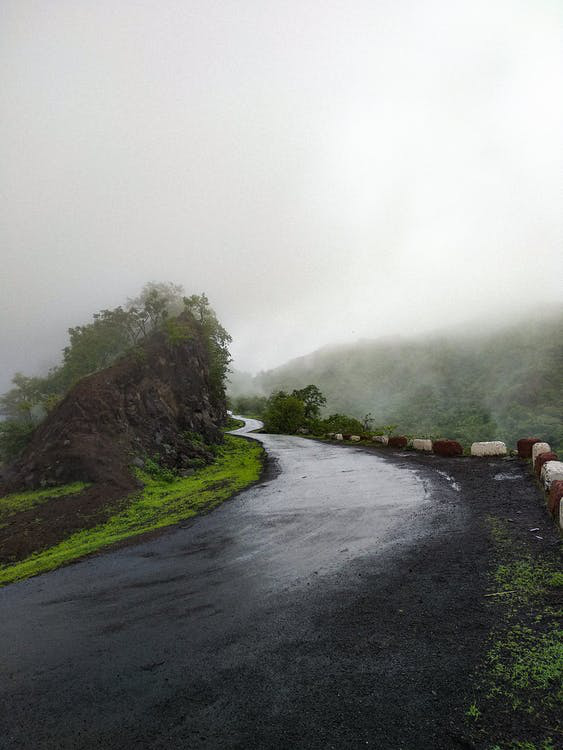

النصوص الشعرية المقترحة


و أنت غيث على ناء ومقترب فصانك الله في حل ومرتحل
وجود أيغد كأن الله أنشأها من كل غيث ضحوك البرق زمزام
يا برق هذا منك أصدق شيمة يا غيث هذا منك أحسن موقعا
والكل ينبوع ماء عين والكل غيث المغيث هاطل
جاد يا قاضي القضاة ضريحا كنت فيه غيث يسر انهماله


In [32]:
#@title
import torch.nn as nn
from PIL import Image
from google.colab import files
import pandas as pd
import requests
import urllib.request
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"

class CLIP_Net(nn.Module):
    def __init__(self, features_image=1280,features_text=768,projection_dim=256,normalize=1):
        super(CLIP_Net, self).__init__()

        self.backbone,  self.preprocessor = clip.load('ViT-B/32', device,jit=False)
        self.Dense=nn.Linear(768,512).to(device)

        self.logit_scale = nn.Parameter(torch.ones([]))

    def forward(self,x_im,x_tx):
    
        image_features, text_features = self.backbone(x_im, x_tx)
        

        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        logit_scale = self.logit_scale.exp()
        logits_per_iamge = logit_scale * image_features @ text_features.t()
        logits_per_text = logit_scale * text_features @ image_features.t()

        return logits_per_iamge, logits_per_text

Poems_model = CLIP_Net().to(device)


checkpoint = torch.load("/content/Poems_model_50_epochs.pt")
checkpoint["input_resolution"] = 224 
checkpoint["context_length"] = 77 
checkpoint["vocab_size"] = Poems_model.backbone.vocab_size 
res = {str(key).replace("backbone.",""): val for key, val in checkpoint['model_state_dict'].items()}
Poems_model.backbone.load_state_dict(res,strict=False)

pd.set_option('display.max_colwidth', None)

df = pd.read_csv("/content/data.csv")
tags = df.groupby(['tags'])['tags'].count().rename_axis('t').reset_index(name='counts')
tags_list = tags['t'].values.tolist()
#print(tags_list)
def prefix_them(text, in_lang='auto', out_lang='en'):
  return "a photo of "+text
tags_list = [prefix_them(str(x)) for x in tags_list]

text = clip.tokenize(tags_list, truncate=True).to(device)


#add pre selected examples :
#https://images.pexels.com/photos/1266810/pexels-photo-1266810.jpeg?auto=compress&cs=tinysrgb&w=300&h=300&dpr=2
#image_url= "https://images.pexels.com/photos/1266810/pexels-photo-1266810.jpeg?auto=compress&cs=tinysrgb&w=300&h=300&dpr=2"
# load image
image = Image.open(requests.get(image_url, stream=True).raw)
print("الصورة المراد معالجتها")
display(image)
image = Poems_model.preprocessor(image).unsqueeze(0).to(device)

with torch.no_grad():
    text_features = Poems_model.backbone.encode_text(text)
    image_features = Poems_model.backbone.encode_image(image)
    logits_per_image, logits_per_text = Poems_model.backbone(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

#print(probs)
#print("Label probs:", probs.max(1))
#print("Label probs:", tags_list[int(probs.argmax(1))])
#print("Label probs:", tags_list[int(probs.argmax(1))])
key = tags_list[int(probs.argmax(1))]
key_df = df[df['tags'].str.contains(key.replace("a photo of ","") )].sample(n=5)
key_df = key_df.drop(['tags'], axis=1)
print("النصوص الشعرية المقترحة")

key_df.style.hide_index().hide_columns()

#display(key_df)